In [3]:
from datascience import Table
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed #pip installed ipywdigets in Terminal
import ipywidgets as widgets
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='KevinMiao', api_key='FZpVgpkGX9s8HNG6MbHJ')
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn

# Let's clean it up 🧽

We pulled the Dataset downloaded from Kaggle (https://www.kaggle.com/jboysen/mri-and-alzheimers). The Datasets have been released as part of OASIS and open-source project aiming to clarify and encourage new discoveries in Alzheimers. The data has been collected by HHMI (Hughes Howard's Medical Institute, University of Washington and Harvard University)

### Cross-Sectional Data


**Cross-Section**, in other words, the plane that consists of the Sagital and Frontal axes.

**1** : We pulled the data. The columns `hand` and `delay` have been removed since the former column only contains right handed people and the latter column does not contribute to the classification or analysis of Alzheimers. Delay is only a technical note about when the data has been processed after the scan.

In [4]:
#pull data
cs = pd.read_csv('oasis_cross-sectional.csv')
cs = cs.drop(['Hand', 'Delay'], axis=1)
cs.head(5)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,NaN,1588,0.803,1.105
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,NaN,1737,0.848,1.010


## Cleaning

The Data have been cleaned, in other words, the redundant columns have been removed. Now we are replacing the `NaN` values by the median. This is very common practice and will help us to buffer for extreme variation, if applicable. The columns that have been cleaned are **`Educ`, `SES`, `MMSE` and `CDR`.** For more information, please read `Phase 0`. Additionally, we have made sure that all values are numerical now; this includes **`M/F`**.

In [5]:
#fill NA values w median values
cs["Educ"] = cs["Educ"].fillna(cs["Educ"].median())
cs["SES"] = cs["SES"].fillna(cs["SES"].median())
cs["MMSE"] = cs["MMSE"].fillna(cs["MMSE"].median())
cs["CDR"] = cs["CDR"].fillna(cs["CDR"].median())

#change categorical variable age to numercail
# M --> 0, F --> 1
cs["M/F"] = cs["M/F"].map(dict({"M": 0, "F": 1}))
cs.head()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


* `0` = Male
* `1` = Female

In [6]:
CrossSectionCleaned = cs.drop(columns = ['ID'])
CrossSectionCleaned.head()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


In [7]:
csgroup1 = cs.groupby("M/F").agg(np.mean)
csgroup1.head(5)

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
M/F,,,,,,,,
0,48.148810,3.142857,2.172619,28.041667,0.157738,1592.410714,0.791452,1.109821
1,53.369403,3.067164,2.287313,27.902985,0.151119,1412.656716,0.791806,1.254731


### Bias?

There does not seem to be a bias between men and female (except for `age`). All variables seem to lie close to each other. The dataset, therefore, is representative and can be used to analyze the data.


In [8]:
print('There is data from ' + str(cs.shape[0]) + ' patients in this set.')

There is data from 436 patients in this set.


### Longitudinal Data


**Longitudinal**, in other words, data collected in the saggital plane.

In [9]:
#pulling the data from csv... drop hand as redundant
lg = pd.read_csv('oasis_longitudinal.csv')
lg = lg.drop('Hand', axis=1)
lg = lg.drop('MR Delay', axis=1)
lg = lg.drop('MRI ID', axis=1)

#going to fill in NA values with the median.. #of NA values too significant to get rid of 
lg["Educ"] = lg["EDUC"].fillna(lg["EDUC"].median())
lg["SES"] = lg["SES"].fillna(lg["SES"].median())
lg["MMSE"] = lg["MMSE"].fillna(lg["MMSE"].median())
lg["CDR"] = lg["CDR"].fillna(lg["CDR"].median())
#change gender M F values to integer values
# M --> 0, F --> 1
lg["M/F"] = lg["M/F"].map(dict({"M": 0, "F": 1}))

lg.head()

,Subject ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
0,OAS2_0001,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,14
1,OAS2_0001,Nondemented,2,0,88,14,2.0,30.0,0.0,2004,0.681,0.876,14
2,OAS2_0002,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046,12
3,OAS2_0002,Demented,2,0,76,12,2.0,28.0,0.5,1738,0.713,1.010,12
4,OAS2_0002,Demented,3,0,80,12,2.0,22.0,0.5,1698,0.701,1.034,12


Same columns have been dropped and cleaned similar to what we did to the cross-sectional dataset. It is worht noting that this table is larger than the one before, since we have extra columns. In addition to this, this DataFrame has a time component to it (Visit) for the same people so we can track the development of the disease.

`Group` 
- `Demented` : Alzheimers
- `Nondemented` : No-Alzheimers
- `Converted` : Developed Alzheimers during the study

In [10]:
lggroup2 = lg.groupby("M/F").agg(np.mean)
lggroup2

,Visit,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
M/F,,,,,,,,,,
0,1.956250,76.681250,14.893750,2.375000,26.637500,0.378125,1604.331250,0.718888,1.106094,14.893750
1,1.826291,77.262911,14.375587,2.483568,27.887324,0.225352,1400.840376,0.737592,1.262592,14.375587


Again, no selection bias since all values lie pretty close to each other irrespective of whether they are sick or not or any other variables. :)

In [11]:
lggroup1 = lg.groupby("Group").agg(np.mean)
lggroup1.head()

,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
Group,,,,,,,,,,,
Converted,2.027027,0.648649,79.756757,15.459459,1.729730,28.675676,0.256757,1459.270270,0.723730,1.212405,15.459459
Demented,1.732877,0.410959,76.260274,13.671233,2.671233,24.575342,0.671233,1485.849315,0.716301,1.196890,13.671233
Nondemented,1.968421,0.678947,77.057895,15.142105,2.394737,29.226316,0.005263,1495.500000,0.740900,1.191063,15.142105


In [12]:
print('There is data from ' + str(lg.shape[0]) + ' patients in this set.')

There is data from 373 patients in this set.


# Trends

In [13]:
def standard_units(data):
    avg = np.average(data)
    stddev = np.std(data)
    return (data - avg) / stdev

In [14]:
def correlation(x, y):
    stdx = standard_units(x)
    stdy = standard_units(y)
    return np.mean(stdx * stdy)

## Age and CDR

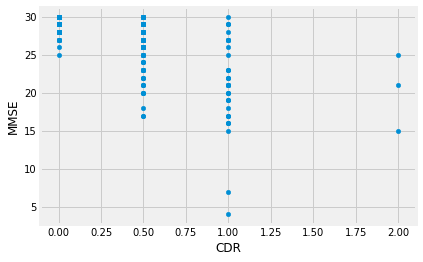

In [15]:
lg.plot.scatter(x='CDR', y = 'MMSE')

In [16]:
cs.head()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


# PCA : LTD

In [17]:
lg.head()

,Subject ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
0,OAS2_0001,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,14
1,OAS2_0001,Nondemented,2,0,88,14,2.0,30.0,0.0,2004,0.681,0.876,14
2,OAS2_0002,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046,12
3,OAS2_0002,Demented,2,0,76,12,2.0,28.0,0.5,1738,0.713,1.010,12
4,OAS2_0002,Demented,3,0,80,12,2.0,22.0,0.5,1698,0.701,1.034,12


In [18]:
lg.describe()

,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,0.571046,77.013405,14.597855,2.436997,27.351206,0.290885,1488.128686,0.729568,1.195461,14.597855
std,0.922843,0.495592,7.640957,2.876339,1.109307,3.675329,0.374557,176.139286,0.037135,0.138092,2.876339
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000,6.000000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000,12.000000
50%,2.000000,1.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000,15.000000
75%,2.000000,1.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000,16.000000
max,5.000000,1.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000,23.000000


In [19]:
features = list(lg)
features.pop(6)
longi = lg.set_index('Subject ID').drop(columns = ['Group', 'Visit', 'Educ'])
longi.head()

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Subject ID,,,,,,,,,
OAS2_0001,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
OAS2_0002,0,76,12,2.0,28.0,0.5,1738,0.713,1.010
OAS2_0002,0,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [21]:
from sklearn.preprocessing import StandardScaler
x = longi.iloc[:, [0,1,2,3,4,6,7,8]].values
y = longi.iloc[:, [5]]
X_std = StandardScaler().fit_transform(x) #standardized data!
X_std

array([[-1.15379808,  1.30873772, -0.20813199, ...,  2.83605891,
        -0.90516867, -2.2657425 ],
       [-1.15379808,  1.43978716, -0.20813199, ...,  2.93270307,
        -1.30964265, -2.31650145],
       [-1.15379808, -0.26385558, -0.90439416, ...,  1.07940909,
         0.17342861, -1.08378418],
       ...,
       [ 0.86670278, -2.09854775, -0.55626308, ..., -0.96148827,
         1.92614919,  0.98283006],
       [ 0.86670278, -1.83644887, -0.55626308, ..., -0.91600866,
         1.79132453,  0.92481984],
       [ 0.86670278, -1.57434999, -0.55626308, ..., -0.88189896,
         1.92614919,  0.88131217]])

# COVARIANCE MATRIX

In [22]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)
#CovarianceMatrix

Covariance matrix 
[[ 1.00268817  0.03782786 -0.0895192   0.048634    0.16898277 -0.57408805
   0.25028903  0.56315721]
 [ 0.03782786  1.00268817 -0.02796079 -0.04553242  0.05540365  0.04246226
  -0.51975265 -0.03516099]
 [-0.0895192  -0.02796079  1.00268817 -0.69307976  0.19267487  0.25770596
  -0.01223243 -0.24240188]
 [ 0.048634   -0.04553242 -0.69307976  1.00268817 -0.14031873 -0.24969899
   0.09260902  0.24147833]
 [ 0.16898277  0.05540365  0.19267487 -0.14031873  1.00268817 -0.03633111
   0.34310855  0.04508105]
 [-0.57408805  0.04246226  0.25770596 -0.24969899 -0.03633111  1.00268817
  -0.21068667 -0.99153479]
 [ 0.25028903 -0.51975265 -0.01223243  0.09260902  0.34310855 -0.21068667
   1.00268817  0.21405   ]
 [ 0.56315721 -0.03516099 -0.24240188  0.24147833  0.04508105 -0.99153479
   0.21405     1.00268817]]


In [25]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.41116657 -0.20790338  0.26182176  0.02168636  0.01580448  0.80728489
  -0.21450774 -0.14396201]
 [ 0.08729181  0.25003517  0.65233843  0.42249289 -0.011453    0.04396983
   0.56764441  0.03914324]
 [ 0.28012881 -0.52256447  0.24025441 -0.27350507 -0.0131347  -0.13834137
   0.17214073 -0.68336208]
 [-0.28299523  0.47495943 -0.32978494  0.30468237 -0.00150229 -0.03781582
   0.0376899  -0.69991783]
 [-0.05563481 -0.4623193   0.04475201  0.74919928 -0.00227055 -0.28029116
  -0.37579095  0.00872971]
 [ 0.55095535  0.03752076 -0.20579801  0.1928641   0.71202923  0.32694753
  -0.01673995 -0.03647558]
 [-0.24230054 -0.42238069 -0.5006289   0.13779978 -0.00940834  0.13073305
   0.6763358   0.13659122]
 [-0.5471811  -0.04523418  0.21080509 -0.18949459  0.70168723 -0.35105618
   0.04223867  0.02846413]]

Eigenvalues 
[2.77819824 1.73148054 1.4085116  0.95377298 0.01080214 0.52227356
 0.3170703  0.29939602]


In [26]:
u,s,v = np.linalg.svd(X_std.T)
u

array([[-0.41116657, -0.20790338,  0.26182176,  0.02168636, -0.80728489,
        -0.21450774,  0.14396201,  0.01580448],
       [ 0.08729181,  0.25003517,  0.65233843,  0.42249289, -0.04396983,
         0.56764441, -0.03914324, -0.011453  ],
       [ 0.28012881, -0.52256447,  0.24025441, -0.27350507,  0.13834137,
         0.17214073,  0.68336208, -0.0131347 ],
       [-0.28299523,  0.47495943, -0.32978494,  0.30468237,  0.03781582,
         0.0376899 ,  0.69991783, -0.00150229],
       [-0.05563481, -0.4623193 ,  0.04475201,  0.74919928,  0.28029116,
        -0.37579095, -0.00872971, -0.00227055],
       [ 0.55095535,  0.03752076, -0.20579801,  0.1928641 , -0.32694753,
        -0.01673995,  0.03647558,  0.71202923],
       [-0.24230054, -0.42238069, -0.5006289 ,  0.13779978, -0.13073305,
         0.6763358 , -0.13659122, -0.00940834],
       [-0.5471811 , -0.04523418,  0.21080509, -0.18949459,  0.35105618,
         0.04223867, -0.02846413,  0.70168723]])

In [33]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.7781982417376305
1.731480541271337
1.4085116045168853
0.953772976421482
0.5222735562341587
0.31707029750977783
0.29939601955560313
0.010802139097212553


In [27]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,5)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,5)], 
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout=dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='selecting-principal-components')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~KevinMiao/0 or inside your plot.ly account where it is named 'selecting-principal-components'


In [34]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
Table().with_column('Variance Explained (%)'
                    , var_exp).with_column('Principal Component #', np.arange(1, 9))

Variance Explained (%),Principal Component #
34.6344,1
21.5855,2
17.5592,3
11.8902,4
6.51092,5
3.95275,6
3.73242,7
0.134665,8


In [35]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), 
                      eig_pairs[1][1].reshape(8,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.41116657 -0.20790338]
 [ 0.08729181  0.25003517]
 [ 0.28012881 -0.52256447]
 [-0.28299523  0.47495943]
 [-0.05563481 -0.4623193 ]
 [ 0.55095535  0.03752076]
 [-0.24230054 -0.42238069]
 [-0.5471811  -0.04523418]]


In [36]:
Y = X_std.dot(matrix_w)
Y #2-dimensional to make it more visually interesting!

array([[ 3.66893322,  1.12397934],
       [ 3.81392488,  0.9556339 ],
       [ 1.52132085,  1.02349865],
       [ 1.93801377,  0.71303543],
       [ 1.93260911,  1.72012583],
       [-1.76632192, -0.19636578],
       [-1.89895611, -0.10509236],
       [ 1.21085994,  1.69299594],
       [ 1.30191467,  1.68158313],
       [ 1.33860569,  1.68874039],
       [-0.27400183, -0.75120878],
       [-0.0459275 , -0.31653471],
       [ 0.1377225 , -0.05359068],
       [-1.36320033,  0.18432574],
       [-1.46829813,  0.31042357],
       [-0.39982026, -0.60626127],
       [-0.09747632, -0.01363761],
       [-1.37570714, -0.62435399],
       [-1.00190835, -0.22226246],
       [-1.20627537, -1.08053125],
       [-1.18905927, -0.90651574],
       [-1.02803605, -0.5807535 ],
       [-2.6355297 ,  0.79443525],
       [-2.79646003,  0.7595273 ],
       [-2.58141308,  1.10537478],
       [ 1.51608875,  1.42081105],
       [ 1.54052247,  2.08957814],
       [ 1.08326316,  3.63696663],
       [ 1.3248203 ,

In [37]:
PCCS = pd.DataFrame(Y, columns=['PC1', 'PC2'])
PCCS.head()

,PC1,PC2
0,3.668933,1.123979
1,3.813925,0.955634
2,1.521321,1.023499
3,1.938014,0.713035
4,1.932609,1.720126


In [42]:
joinedlg = PCCS.join(lg)
joinedlg.head()

,PC1,PC2,Subject ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
0,3.668933,1.123979,OAS2_0001,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,14
1,3.813925,0.955634,OAS2_0001,Nondemented,2,0,88,14,2.0,30.0,0.0,2004,0.681,0.876,14
2,1.521321,1.023499,OAS2_0002,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046,12
3,1.938014,0.713035,OAS2_0002,Demented,2,0,76,12,2.0,28.0,0.5,1738,0.713,1.010,12
4,1.932609,1.720126,OAS2_0002,Demented,3,0,80,12,2.0,22.0,0.5,1698,0.701,1.034,12


In [44]:
tabularlg = joinedlg[['PC1', 'PC2', 'CDR']]
tabularlg.head()

,PC1,PC2,CDR
0,3.668933,1.123979,0.0
1,3.813925,0.955634,0.0
2,1.521321,1.023499,0.5
3,1.938014,0.713035,0.5
4,1.932609,1.720126,0.5


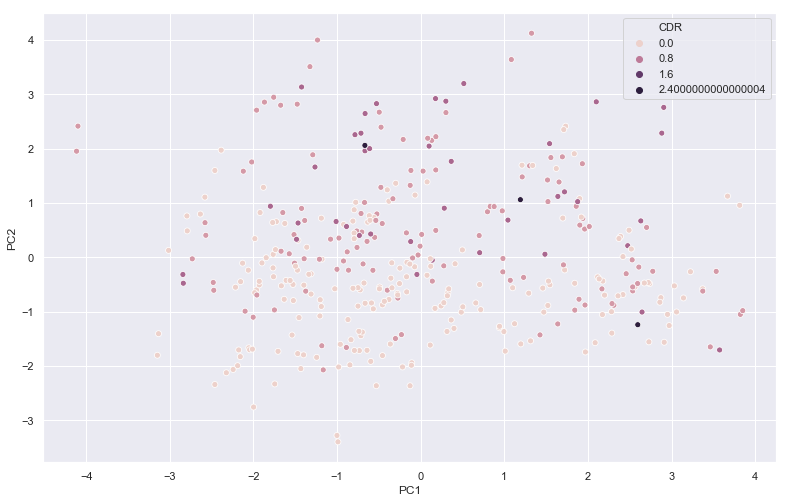

In [46]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
ax = seaborn.scatterplot(x="PC1", y="PC2", hue = 'CDR', data=tabularlg)